<a href="https://colab.research.google.com/github/JacksonLeb/tensorflow_learning/blob/main/05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine Tuning

In [1]:
!nvidia-smi

Thu Jul 14 21:39:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##importing from github

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-14 21:39:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-14 21:39:21 (96.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



##importing from github file in google colab file structure

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

##Getting data

In [4]:
#Getting 10% training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-14 21:39:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   150MB/s    in 1.1s    

2022-07-14 21:39:28 (150 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data("10_food_classes_10_percent.zip")

In [6]:
#Checking num images and subdirectories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [7]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
import tensorflow as tf
IMG_SIZE = (244,244)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
train_data_10_percent,
test_data

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
train_data_10_percent.take

<bound method DatasetV2.take of <BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>>

In [11]:
#example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[193.70311   194.44444   189.57378  ]
   [194.86066   195.28688   190.57378  ]
   [196.28688   195.28688   193.28688  ]
   ...
   [146.47292   108.186386  112.94856  ]
   [152.79199    96.99995   110.41789  ]
   [161.23773    96.43086   113.752335 ]]

  [[197.56013   195.54918   191.86066  ]
   [199.27863   195.69666   192.55731  ]
   [199.58197   196.        193.13934  ]
   ...
   [133.89395    95.40273   102.52822  ]
   [153.20448   100.50799   113.51613  ]
   [164.56563   104.169464  122.03012  ]]

  [[200.86885   193.69672   191.56557  ]
   [201.15016   193.97803   191.84688  ]
   [202.43443   193.56557   192.       ]
   ...
   [148.56198   114.02939   120.90193  ]
   [161.21498   117.081406  129.33797  ]
   [155.11656   105.77144   121.33701  ]]

  ...

  [[195.13116   175.13116   174.13116  ]
   [195.        175.        174.       ]
   [194.57814   174.57814   173.57814  ]
   ...
   [148.8639    122.86391   150.73274  ]
   [151.64697   127.99939   153.99939  ]
   [1

#Keras functional API

In [12]:
#Building transfer leanring model
#Funcitonal api gives more flexibility with our models
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#creating inputs for model
inputs = tf.keras.layers.Input(shape=(244,244,3), name="input_layer")

#If using ResNet50V2 you will need to normalize layers
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
print(f"Base model shape: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
print(f"Shape after global avg pooling:{x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)


model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=int(.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="10percentfeatureextraction")]
                                )

16719872/16705208 [==============================] - 0s 0us/step
Base model shape: (None, 7, 7, 1280)
Shape after global avg pooling:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10percentfeatureextraction/20220714-213940
Epoch 1/5
24/24 [==============================] - 24s 278ms/step - loss: 1.9154 - accuracy: 0.3987 - val_loss: 1.3156 - val_accuracy: 0.6842
Epoch 2/5
24/24 [==============================] - 5s 195ms/step - loss: 1.1440 - accuracy: 0.7347 - val_loss: 0.8589 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - 5s 195ms/step - loss: 0.8442 - accuracy: 0.8093 - val_loss: 0.7133 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 5s 172ms/step - loss: 0.6821 - accuracy: 0.8400 - val_loss: 0.6440 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 5s 195ms/step - loss: 0.5864 - accuracy: 0.8707 - val_loss: 0.5448 - val_accuracy: 0.8553


In [13]:
#evaluation
model_0.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.5992 - accuracy: 0.8444


[0.5991775393486023, 0.8443999886512756]

In [14]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

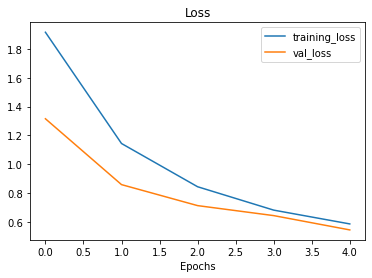

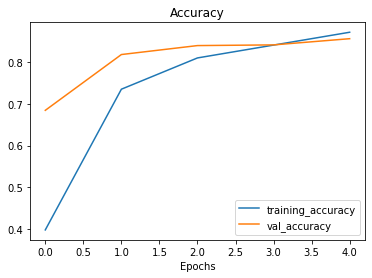

In [16]:
plot_loss_curves(history_10_percent)

#Getting feature vector from trainned model using Global average pooling layer

In [17]:
input_shape = (1,4,4,3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random Tensor: {input_tensor}")

Random Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [18]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2d global average pooled tensor: {global_average_pooled_tensor}")

2d global average pooled tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]


In [19]:
print(f"input tensor: {input_tensor.shape}")
print(f"global average tensor: {global_average_pooled_tensor.shape}")

input tensor: (1, 4, 4, 3)
global average tensor: (1, 3)


In [20]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

##Transfer learning experiments

In [21]:
#Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-07-14 21:45:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 64.233.182.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   186MB/s    in 0.7s    

2022-07-14 21:45:32 (186 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [23]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [24]:
#preprocessing the data
IMG_SIZE = (244,244)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#Augmenting the data while in the model

In [25]:
print(tf.__version__)

2.8.2


In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.Rescaling(1./255),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation")

###visualizing our data augmentation data

In [29]:
#viewing random image and comparing to augmented counterpart

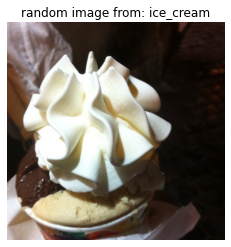

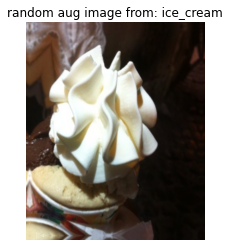

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.title(f"random image from: {target_class}")
plt.axis(False)
plt.imshow(img)

#augmented image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.title(f"random aug image from: {target_class}")
plt.axis(False)
plt.imshow(augmented_img)



In [55]:
#feature extraction on 1% data
input_shape = (244,244,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

#data aug as layer
x = data_augmentation(inputs)

#give base model inputs after aug
x = base_model(x, training=False)

#pooling feature tensor
x = layers.GlobalAveragePooling2D(name="global_pooling_layer")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

In [59]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data,
            validation_steps=(0.25*len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="FeatureExtraction1Percent")])

Saving TensorBoard log files to: transfer_learning/FeatureExtraction1Percent/20220714-221856
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3475 - accuracy: 0.0857 - val_loss: 2.3196 - val_accuracy: 0.0969
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.3287 - accuracy: 0.0857 - val_loss: 2.3101 - val_accuracy: 0.1000
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.3166 - accuracy: 0.1000 - val_loss: 2.3158 - val_accuracy: 0.1031
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 2.3035 - accuracy: 0.0714 - val_loss: 2.3185 - val_accuracy: 0.1109
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 2.3367 - accuracy: 0.1000 - val_loss: 2.3259 - val_accuracy: 0.1125


In [57]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pooling_layer (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [58]:
model_1.evaluate(test_data)

79/79 [==============================] - 9s 101ms/step - loss: 2.3316 - accuracy: 0.1000


[2.331632137298584, 0.10000000149011612]

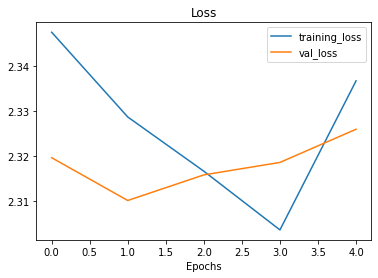

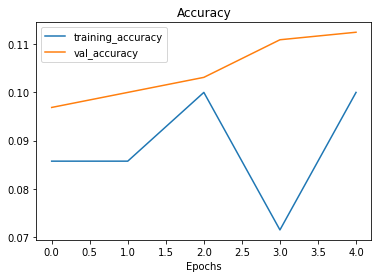

In [60]:
plot_loss_curves(history_1_percent)

In [70]:
import tensorflow as tf
IMG_SIZE = (244,244)

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
], name="data_augmentation")


#set up input shape
input_shape = (244,244,3)

#create frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create the input and outputs including the layers in between
inputs = layers.Input(input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
